In [1]:
import os
from tqdm import tqdm
import pickle
import random

import pandas as pd
import numpy as np
import scipy
from sklearn.metrics.pairwise import pairwise_kernels
from sklearn import preprocessing
import matplotlib.pyplot as plt

from metaspace import SMInstance
from anndata import AnnData
from metaspace_converter import metaspace_to_anndata
import scanpy as sc
import seaborn as sns
from collections import defaultdict, Counter
from molmass import Formula

In [2]:
import utils
import coloc_utils
from coloc_utils import *
from config import store_dir, data_dir, date_key, figuredata_dir
%load_ext autoreload
%autoreload 2

/home/trose/.conda/envs/metabolomics2/lib/python3.10/site-packages/linex2/parser.py:22: RuntimeWarning: Package 'lynx' (LipidLynxX) not available. Lipid name conversions will not be possible.
  warnings.warn(


# Load data

In [3]:
dss = pickle.load(open(os.path.join(store_dir, 'all_datasets.pickle'), "rb" ) )

Don't run the following two cells

In [4]:
results = pickle.load(open(os.path.join(store_dir, 'hmdb4_results.pickle'), "rb" ) )

In [5]:
# Only run if isobar free results is not already cached. 
results = coloc_utils.mark_isobars_resultstab(results, remove=True)
pickle.dump(results, open( os.path.join(store_dir, 'hmdb4_results_IsobarFree.pickle'), "wb" ))

  0%|          | 0/7443 [00:00<?, ?it/s]/home/trose/projects/metaspace_evaluation/coloc_utils.py:537: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  tmp[idx] = False
  0%|          | 1/7443 [00:00<54:24,  2.28it/s]/home/trose/projects/metaspace_evaluation/coloc_utils.py:537: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  tmp[idx] = False
  0%|          | 2/7443 [00:00<49:56,  2.48it/s]/home/trose/projects/metaspace_evaluation/coloc_utils.py:537: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFr

KeyboardInterrupt: 

In [4]:
# File not available on GitHub, get in touch with METASPACE developers to get access (contact@metaspace2020.eu)
hmdb_v4 = pd.read_csv('database/HMDB_v4.csv', index_col=None).set_index('chemical_formula')

In [5]:
results = pickle.load(open(os.path.join(store_dir, 'hmdb4_results_IsobarFree.pickle'), "rb" ) )

In [6]:
len(results)

7443

In [7]:
md = utils.make_metadata_dict(dss, results, only_results=True)
mdt = utils.clean_metadata_table(utils.metadata_dict_totable(md))

In [8]:
mdt['top_Organism'] = utils.top_feature_col(mdt['Organism'], top=6, exclusion_list=['N/A', 'cultured cells', 'Multiple'])
mdt['top_Condition'] = utils.top_feature_col(mdt['Condition'], top=10)
mdt['top_Organism_Part'] = utils.top_feature_col(mdt['Organism_Part'], top=10)
mdt['top_Polarity'] = utils.top_feature_col(mdt['Polarity'], top=10)
mdt['top_maldi_matrix'] = utils.top_feature_col(mdt['maldi_matrix'], top=8)
mdt['top_Group'] = utils.top_feature_col(mdt['Group'], top=10, exclusion_list=['not available'])

/home/trose/projects/metaspace_evaluation/utils.py:108: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tmp = pd.value_counts(in_col)
/home/trose/projects/metaspace_evaluation/utils.py:108: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tmp = pd.value_counts(in_col)
/home/trose/projects/metaspace_evaluation/utils.py:108: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tmp = pd.value_counts(in_col)
/home/trose/projects/metaspace_evaluation/utils.py:108: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tmp = pd.value_counts(in_col)
/home/trose/projects/metaspace_evaluation/utils.py:108: FutureWarning: pandas.value_counts is deprecated and will be

# Case Study 1

In [9]:
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


In [10]:
# We are working with molecules as features
adata_mol = utils.make_molecule_anndata(results, mdt, fdr_cutoff=0.2, only_onSample=True)

100%|██████████| 7443/7443 [00:08<00:00, 849.38it/s]


10745  features


100%|██████████| 7443/7443 [00:32<00:00, 226.59it/s]
/home/trose/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [11]:
# Positive data
adata_mol_pos = adata_mol[adata_mol.obs['Polarity']=='Positive',:]
adata_mol_pos.var = adata_mol_pos.var = adata_mol_pos.var.rename(columns={0: 'molecule'}).reset_index().set_index('molecule').drop(columns='index')
sc.pp.filter_genes(adata_mol_pos, min_cells=100)
sc.pp.filter_cells(adata_mol_pos, min_genes=20)
sc.pp.normalize_total(adata_mol_pos, target_sum=1e4)

sc.pp.neighbors(adata_mol_pos, metric='cosine')
sc.tl.leiden(adata_mol_pos)
sc.tl.umap(adata_mol_pos)

# Negative data
adata_mol_neg = adata_mol[adata_mol.obs['Polarity']=='Negative',:]
adata_mol_neg.var = adata_mol_neg.var = adata_mol_neg.var.rename(columns={0: 'molecule'}).reset_index().set_index('molecule').drop(columns='index')
sc.pp.filter_genes(adata_mol_neg, min_cells=100)
sc.pp.filter_cells(adata_mol_neg, min_genes=20)
sc.pp.normalize_total(adata_mol_neg, target_sum=1e4)

sc.pp.neighbors(adata_mol_neg, metric='cosine')
sc.tl.leiden(adata_mol_neg)
sc.tl.umap(adata_mol_neg)

         Falling back to preprocessing with `sc.pp.pca` and default params.


/home/trose/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/trose/.conda/envs/metabolomics2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


         Falling back to preprocessing with `sc.pp.pca` and default params.


/home/trose/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


In [14]:
adata_mol_pos

AnnData object with n_obs × n_vars = 1881 × 523
    obs: 'Organism', 'Condition', 'Organism_Part', 'Polarity', 'maldi_matrix', 'Group', 'mzmin', 'mzmax', 'Analyzer', 'Ionisation_Source', 'top_Organism', 'top_Condition', 'top_Organism_Part', 'top_Polarity', 'top_maldi_matrix', 'top_Group', 'n_genes', 'leiden'
    var: 'n_cells'
    uns: 'neighbors', 'leiden', 'umap'
    obsm: 'X_pca', 'X_umap'
    obsp: 'distances', 'connectivities'

In [15]:
adata_mol_neg

AnnData object with n_obs × n_vars = 2046 × 689
    obs: 'Organism', 'Condition', 'Organism_Part', 'Polarity', 'maldi_matrix', 'Group', 'mzmin', 'mzmax', 'Analyzer', 'Ionisation_Source', 'top_Organism', 'top_Condition', 'top_Organism_Part', 'top_Polarity', 'top_maldi_matrix', 'top_Group', 'n_genes', 'leiden'
    var: 'n_cells'
    uns: 'neighbors', 'leiden', 'umap'
    obsm: 'X_pca', 'X_umap'
    obsp: 'distances', 'connectivities'

In [11]:
organism_colors = {k: v for k, v in zip(mdt['top_Organism'].value_counts().index, list(plt.get_cmap('tab10').colors)[:len(set(mdt['top_Organism']))])}
organ_colors = {k: v for k, v in zip(mdt['top_Organism_Part'].value_counts().index, list(plt.get_cmap('tab10').colors)[:len(set(mdt['top_Organism_Part']))])}
pickle.dump(organ_colors, open(os.path.join(store_dir, 'organ_colors.pickle'), "wb" ) )

In [12]:
def draw_umapaxis(ax, length_mul=.1, yoffset=0.):
    xlims = ax.get_xlim()
    ylims = ax.get_ylim()
    
    deltax = xlims[1] - xlims[0]
    deltay = ylims[1] - ylims[0]
    
    # X-Annotation
    ax.annotate('', xy=(xlims[0]+length_mul*deltax, ylims[0]+yoffset), xytext=(xlims[0], ylims[0]+yoffset), 
                arrowprops=dict(arrowstyle='->', color='black'))
    ax.annotate('UMAP1', (xlims[0]+length_mul*deltax, ylims[0]+yoffset), ha='left', va='center', fontsize=XSMALL_SIZE)
    
    ax.annotate('', xy=(xlims[0], ylims[0]+length_mul*deltay+yoffset), xytext=(xlims[0], ylims[0]+yoffset), 
                arrowprops=dict(arrowstyle='->', color='black'))
    ax.annotate('UMAP2', (xlims[0], ylims[0]+length_mul*deltay+yoffset), ha='center', va='bottom', fontsize=XSMALL_SIZE)

## Common classes of metabolites

In [13]:
hmdb4_metclasses = pd.read_csv(os.path.join(data_dir, 'databases', 'HMDB_v4.csv'))

super_class_dict = dict(zip(hmdb4_metclasses.accession, hmdb4_metclasses.super_class))
class_dict = dict(zip(hmdb4_metclasses.accession, hmdb4_metclasses['class']))
sub_class_dict = dict(zip(hmdb4_metclasses.accession, hmdb4_metclasses.sub_class))
status_dict = dict(zip(hmdb4_metclasses.accession, hmdb4_metclasses.status))

In [14]:
# Get counts for classes
def ontology_counts(ont_dict):
    count_dict = {}
    for hmdbid, ont in ont_dict.items():
        if ont not in count_dict.keys():
            count_dict[ont] = 1
        else:
            count_dict[ont] += 1
    return count_dict

In [15]:
# For each dataset, make a list of lists with HMDB accessions
fdr_cutoff = 0.2

metaspace_annotation_super_class = {}
metaspace_annotation_class = {}
metaspace_annotation_sub_class = {}

for i in tqdm(results.keys()):
    # Get all moleculeids:
    tmp_ids = list(results[i][results[i]['fdr'] <= fdr_cutoff]['moleculeIds'])
    
    metaspace_annotation_super_class[i] = []
    metaspace_annotation_class[i] = []
    metaspace_annotation_sub_class[i] = []
    
    # loop over each annotation (ion)
    for io in tmp_ids:
        # ion = ast.literal_eval(io)
        ion = io
        if (len(ion)) == 1:
            if ion[0] in super_class_dict.keys():
                metaspace_annotation_super_class[i].append([super_class_dict[ion[0]]])
                metaspace_annotation_class[i].append([class_dict[ion[0]]])
                metaspace_annotation_sub_class[i].append([sub_class_dict[ion[0]]])
        else:
            tmp_super_class = []
            tmp_class = []
            tmp_sub_class = []
            for ann in ion:
                if status_dict.get(ann, 'not found') == 'quantified' or status_dict.get(ann, 'not found') == 'detected':
                    tmp_super_class.append(super_class_dict[ann])
                    tmp_class.append(class_dict[ann])
                    tmp_sub_class.append(sub_class_dict[ann])
            if len(tmp_super_class)>0: metaspace_annotation_super_class[i].append(tmp_super_class)
            if len(tmp_class)>0: metaspace_annotation_class[i].append(tmp_class)
            if len(tmp_sub_class)>0: metaspace_annotation_sub_class[i].append(tmp_sub_class)

100%|██████████| 7443/7443 [00:16<00:00, 465.06it/s] 


## Marker

In [16]:
sc.tl.rank_genes_groups(adata_mol_neg, 'top_Organism_Part', method='wilcoxon')
sc.tl.rank_genes_groups(adata_mol_pos, 'top_Organism_Part', method='wilcoxon')

excluded = ['Whole organism', 'Other', 'Lymph node']

/home/trose/.conda/envs/metabolomics2/lib/python3.10/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
/home/trose/.conda/envs/metabolomics2/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:419: RuntimeWarning: overflow encountered in expm1
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/home/trose/.conda/envs/metabolomics2/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:419: RuntimeWarning: overflow encountered in expm1
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/home/trose/.conda/envs/metabolomics2/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:419: RuntimeWarning: overflow encountered in expm1
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (
/home/tros

In [17]:
marker_index = []
pos_marker = []
curr_excluded = excluded.copy()
for organ in set(adata_mol_pos.obs['top_Organism_Part']):
    if organ not in excluded:
        tmpdf = sc.get.rank_genes_groups_df(adata_mol_pos, organ)
        tmpdf = tmpdf[tmpdf['pvals_adj'] <= 0.05]
        # tmpdf = tmpdf[tmpdf['logfoldchanges'] < np.inf]
        mol = tmpdf.sort_values('scores', ascending=False)['names'].values[0]
        # Potential isobar issues which, therefore we don't use them
        if mol in ['C44H76NO8P']:
            mol = tmpdf.sort_values('scores', ascending=False)['names'].values[1]
        
        if tmpdf.sort_values('scores', ascending=False)['scores'].values[0] <= 0:
            curr_excluded.append(organ)
        # mol = sc.get.rank_genes_groups_df(adata_mol_pos, organ).sort_values('scores', ascending=False)
        else:
            print(f'{organ}: {mol}')
            pos_marker.append(mol)
            marker_index.append(organ)

pos_marker = pd.Series(pos_marker, index=marker_index)

# tmp = adata_mol_pos[:, pos_marker].copy()
# marker_df = pd.DataFrame(tmp.X, index=tmp.obs['top_Organism_Part'], columns=pos_marker).apply(scipy.stats.zscore)
# marker_df = marker_df.reset_index().groupby('top_Organism_Part').agg('mean')
# sns.clustermap(marker_df)
adata_mol_pos.layers['scaled'] = sc.pp.scale(adata_mol_pos, copy=True).X

adata_marker_pos = adata_mol_pos[~adata_mol_pos.obs['top_Organism_Part'].isin(excluded), :]

Lung: C40H78NO8P
Liver: C43H80NO8P
Kidney: C42H80NO8P
Root: C12H22O11
Brain: C41H83N2O6P


In [18]:
sc.get.rank_genes_groups_df(adata_mol_pos, 'Brain')

,names,scores,logfoldchanges,pvals,pvals_adj
0,C41H83N2O6P,18.848724,486.605164,3.010120e-79,7.871464e-77
1,C48H91NO8,17.071474,163.288437,2.420138e-65,4.219107e-63
2,C45H78NO8P,15.565968,121.059761,1.239807e-54,1.621047e-52
3,C44H86NO8P,13.323254,401.838348,1.695533e-40,1.266805e-38
4,C27H44NO7P,12.281057,30.932802,1.144923e-34,7.484933e-33
...,...,...,...,...,...
518,C41H75O8P,-10.560684,-37.927830,4.533450e-26,1.693567e-24
519,C44H82NO8P,-12.049900,-217.790710,1.941861e-33,1.128437e-31
520,C37H66O4,-14.194651,-64.718910,9.887832e-46,8.618894e-44
521,C39H71O8P,-15.501745,-91.915558,3.375969e-54,3.531263e-52


In [19]:
7*10e-3

0.07

In [20]:
marker_index = []
neg_marker = []
curr_excluded = excluded.copy()
for organ in set(adata_mol_neg.obs['top_Organism_Part']):
    if organ not in excluded:
        tmpdf = sc.get.rank_genes_groups_df(adata_mol_neg, organ)
        tmpdf = tmpdf[tmpdf['pvals_adj'] <= 0.05]
        mol = tmpdf.sort_values('scores', ascending=False)['names'].values[0]
        # Potential isobar issues which, therefore we don't use them
        if mol in ['C44H76NO8P']:
            mol = tmpdf.sort_values('scores', ascending=False)['names'].values[1]
        if tmpdf.sort_values('scores', ascending=False)['scores'].values[0] <= 0:
            curr_excluded.append(organ)
        # mol = sc.get.rank_genes_groups_df(adata_mol_pos, organ).sort_values('scores', ascending=False)
        else:
            print(f'{organ}: {mol}')
            neg_marker.append(mol)
            marker_index.append(organ)

neg_marker = pd.Series(neg_marker, index=marker_index)

# tmp = adata_mol_neg[:, neg_marker].copy()
# marker_df = pd.DataFrame(tmp.X, index=tmp.obs['top_Organism_Part'], columns=neg_marker).apply(scipy.stats.zscore)
# marker_df = marker_df.reset_index().groupby('top_Organism_Part').agg('mean')
# sns.clustermap(marker_df)

adata_mol_neg.layers['scaled'] = sc.pp.scale(adata_mol_neg, copy=True).X

adata_marker_neg = adata_mol_neg[~adata_mol_neg.obs['top_Organism_Part'].isin(excluded), :]

Breast: C39H74NO7P
Liver: C26H45NO7S
Lung: C40H77O10P
Leaf: C15H10O5
Kidney: C5H9NO4
Root: C16H12O5
Brain: C45H78NO8P


In [21]:
def marker_heatmap(adata, marker, ax):
    df =  pd.DataFrame(adata.X, columns=adata.var.index, index=adata.obs.index)
    df = df[marker]
    df = pd.DataFrame(preprocessing.StandardScaler().fit_transform(df), index=df.index, columns=df.columns).reset_index()
    df = pd.melt(df, id_vars='index').set_index('index')
    df = df.join(adata.obs[['top_Organism_Part']]).reset_index(drop=True)
    df = df.groupby(['molecule', 'top_Organism_Part']).agg('mean').reset_index()
    df = df.pivot(columns='molecule', index='top_Organism_Part')
    df.columns = df.columns.droplevel(0)
    sns.heatmap(df, cmap='RdBu_r', center=0, ax=ax)  # , cbar_kws={'label': 'z-score'}

In [22]:
selected_visualizations = [
    ('Brain', '2022-01-31_09h08m54s', 'C41H83N2O6P', '+K', []),
    ('Lung', '2020-12-22_23h04m28s', 'C40H78NO8P', '+Na', []),
    ('Kidney', '2021-01-22_21h03m20s', 'C42H80NO8P', '+K', []),
    ('Root', '2022-04-16_01h14m55s', 'C12H22O11', '+K', [])
]

sm = SMInstance()

for i in range(len(selected_visualizations)):
    ds = sm.dataset(id=selected_visualizations[i][1])
    images = ds.isotope_images(selected_visualizations[i][2], selected_visualizations[i][3])
    image = images[0]
    # Hotspot clipping
    hotspot = np.percentile(image, 99)
    image[image > hotspot] = hotspot
    selected_visualizations[i] = (selected_visualizations[i][0], selected_visualizations[i][1], selected_visualizations[i][2], selected_visualizations[i][3], image)

## Figure assembly

In [23]:
def ax_ann(fig, ax, letter='A', xoffset=0, yoffset=0, **kwargs):

    axes_position = ax.get_position()
    # Extract position and size information
    left, bottom, width, height = axes_position.bounds
    
    fig.text(left+xoffset, bottom+height+yoffset, letter, **kwargs)

In [24]:
from matplotlib.lines import Line2D

def pieplot(data, ax, colors=None):
    data=dat.values
    data = (data/data.sum())*100
    labels = dat.index
    if colors is None:
        patches, texts = ax.pie(data, startangle=90)
    else:
        patches, texts = ax.pie(data, colors=[colors[x] for x in labels], startangle=90)
    ax.legend(patches, labels, loc='center left', bbox_to_anchor=(1, 0.5))
    
def increase_legend_patchsize(ax, size=.5, **kwargs):
    leg = ax.legend()
    handles, labels = ax.get_legend_handles_labels()
    patches=[]
    for handle, label in zip(handles, labels):
        patches.append(Line2D([], [], color=handle.get_color(), label=label, linewidth=size, marker='o', linestyle=''))
    legend = ax.legend(handles=patches, **kwargs)

/tmp/ipykernel_334/152682660.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = df.groupby(['molecule', 'top_Organism_Part']).agg('mean').reset_index()
/tmp/ipykernel_334/152682660.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = df.groupby(['molecule', 'top_Organism_Part']).agg('mean').reset_index()
/home/trose/.conda/envs/metabolomics2/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


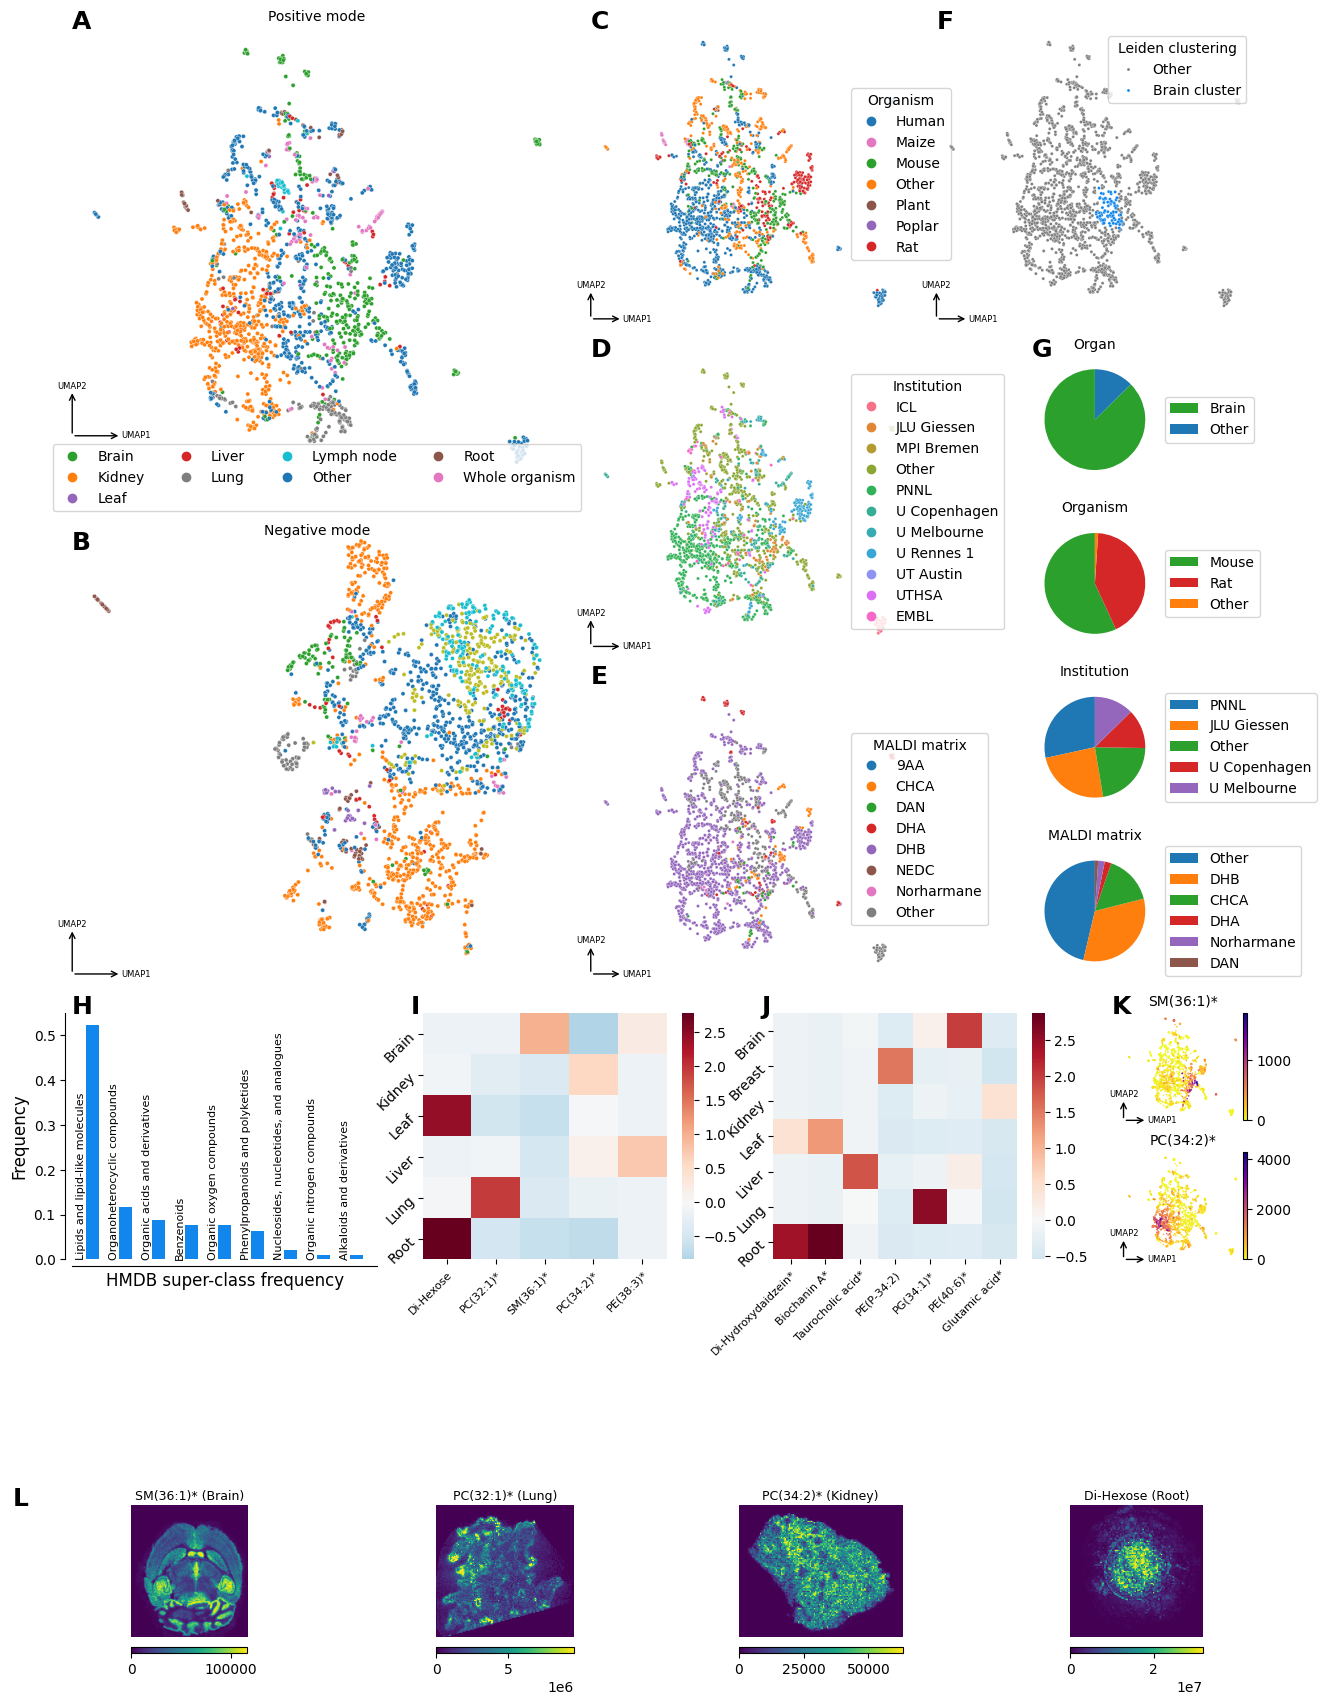

In [39]:
fig = plt.figure(figsize=(30*cm, 45*cm))
(topfig, middlefig, bottomfig) = fig.subfigures(3, 1, height_ratios=[3, 1.5, .9])

gs = plt.GridSpec(nrows=6, ncols=7)

topfig.subplots_adjust(left=.0, right=1., bottom=0.04, top=1., hspace=.3)

ax_posumap = topfig.add_subplot(gs[0:3, 0:3])
ax_negumap = topfig.add_subplot(gs[3:6, 0:3])
ax_umap1 = topfig.add_subplot(gs[0:2, 3:5])
ax_umap2 = topfig.add_subplot(gs[2:4, 3:5])
ax_umap3 = topfig.add_subplot(gs[4:6, 3:5])
ax_umap4 = topfig.add_subplot(gs[0:2, 5:7])
ax_pie1 = topfig.add_subplot(gs[2, 5:7])
ax_pie2 = topfig.add_subplot(gs[3, 5:7])
ax_pie3 = topfig.add_subplot(gs[4, 5:7])
ax_pie4 = topfig.add_subplot(gs[5, 5:7])


pos_umap = adata_mol_pos.obs.reset_index().join(pd.DataFrame(adata_mol_pos.obsm['X_umap']).rename(columns={0: 'x', 1: 'y'})).rename(columns={'top_Organism_Part': 'Organ',})
sns.scatterplot(data=pos_umap, x='x', y='y', hue='Organ', s=9, palette=organ_colors, ax=ax_posumap)
ax_posumap.set_title('Positive mode')
ax_posumap.axis('off')
draw_umapaxis(ax_posumap, yoffset=2.5)
increase_legend_patchsize(ax_posumap, size=.5, loc='upper center', bbox_to_anchor=(0.5, .1), ncol=4)
ax_ann(topfig, ax_posumap, letter='A', size=BIGGER_SIZE, weight='bold')



neg_umap = adata_mol_neg.obs.reset_index().join(pd.DataFrame(adata_mol_neg.obsm['X_umap']).rename(columns={0: 'x', 1: 'y'})).rename(columns={'top_Organism_Part': 'Organ',})
sns.scatterplot(data=neg_umap, x='x', y='y', hue='Organ', s=9, palette=organ_colors, ax=ax_negumap)
ax_negumap.set_title('Negative mode', y=.95)
ax_negumap.axis('off')
ax_negumap.get_legend().remove()
draw_umapaxis(ax_negumap)
#ax_negumap.text(0.01, .9, 'B', transform=ax_negumap.transAxes, size=BIGGER_SIZE, weight='bold')
ax_ann(topfig, ax_negumap, letter='B', size=BIGGER_SIZE, weight='bold', yoffset=-.03)


sns.scatterplot(data=pos_umap.drop(columns=['Organism']).rename(columns={'top_Organism': 'Organism'}), x='x', y='y', hue='Organism', s=5, palette=organism_colors, ax=ax_umap1)
ax_umap1.axis('off')
draw_umapaxis(ax_umap1)
increase_legend_patchsize(ax_umap1, size=.5, title='Organism', loc='center left', bbox_to_anchor=(.8, 0.5))
ax_ann(topfig, ax_umap1, letter='C', size=BIGGER_SIZE, weight='bold')

tmp = pos_umap.rename(columns={'top_Group': 'Institution'})
tmp['Institution'] = tmp['Institution'].replace({'♡EMBL♡': 'EMBL'})
sns.scatterplot(data=tmp, x='x', y='y', hue='Institution', s=5, ax=ax_umap2)
ax_umap2.axis('off')
draw_umapaxis(ax_umap2)
increase_legend_patchsize(ax_umap2, size=.5, title='Institution', loc='center left', bbox_to_anchor=(.8, 0.5))
ax_ann(topfig, ax_umap2, letter='D', size=BIGGER_SIZE, weight='bold')

sns.scatterplot(data=pos_umap.rename(columns={'top_maldi_matrix': 'MALDI matrix'}), x='x', y='y', hue='MALDI matrix', s=5, ax=ax_umap3)
ax_umap3.axis('off')
draw_umapaxis(ax_umap3)
increase_legend_patchsize(ax_umap3, size=.5, title='MALDI matrix', loc='center left', bbox_to_anchor=(.8, 0.5))
ax_ann(topfig, ax_umap3, letter='E', size=BIGGER_SIZE, weight='bold')


# Brain cluster
maxleid = (0, 0, 0)
pos_umap = adata_mol_pos.obs.reset_index().join(pd.DataFrame(adata_mol_pos.obsm['X_umap']).rename(columns={0: 'x', 1: 'y'}))
for leid in set(pos_umap['leiden']):
    curr_leid = pos_umap[pos_umap['leiden'] == leid]
    vc = curr_leid['top_Organism_Part'].value_counts()
    
    if 'Brain' in vc:
        brain = vc['Brain']
        if brain > maxleid[1]:
            maxleid = (leid, brain, brain / curr_leid.shape[0])
        
pos_umap['Leiden clustering'] = pos_umap['leiden'].apply(lambda x: 'Brain cluster' if x==maxleid[0] else 'Other')

sns.scatterplot(data=pos_umap, x='x', y='y', hue='Leiden clustering', s=5, palette={'Brain cluster': '#1187ee', 'Other': 'grey'}, ax=ax_umap4)
ax_umap4.axis('off')
draw_umapaxis(ax_umap4)
#ax_umap4.text(-.01, .9, 'F', transform=ax_umap4.transAxes, size=BIGGER_SIZE, weight='bold')
sns.move_legend(ax_umap4, "upper right")
ax_ann(topfig, ax_umap4, letter='F', size=BIGGER_SIZE, weight='bold')


# Piecharts

curr_data = pos_umap[pos_umap['leiden'] == maxleid[0]]

dat = curr_data['top_Organism_Part'].value_counts()
dat = dat[dat> 0]
pieplot(dat, ax_pie1, colors=organ_colors)
ax_pie1.set_title('Organ')
ax_ann(topfig, ax_pie1, letter='G', size=BIGGER_SIZE, weight='bold')

dat = curr_data['top_Organism'].value_counts()
dat = dat[dat> 0]
pieplot(dat, ax_pie2, colors=organism_colors)
ax_pie2.set_title('Organism')

dat = curr_data['top_Group'].value_counts()
dat = dat[dat> 0]
pieplot(dat, ax_pie3)
ax_pie3.set_title('Institution')

dat = curr_data['top_maldi_matrix'].value_counts()
dat = dat[dat> 0]
pieplot(dat, ax_pie4)
ax_pie4.set_title('MALDI matrix')
# ax_pie4.legend()




# Middle panel

gs2 = plt.GridSpec(nrows=2, ncols=7)
middlefig.subplots_adjust(left=.0, right=1., bottom=0.5, top=1., hspace=.3, wspace=.35)

ax_hmdb = middlefig.add_subplot(gs2[0:2, 0:2])
ax_marker1 = middlefig.add_subplot(gs2[0:2, 2:4])
ax_marker2 = middlefig.add_subplot(gs2[0:2, 4:6])
ax_umap5 = middlefig.add_subplot(gs2[0, 6])
ax_umap6 = middlefig.add_subplot(gs2[1, 6])

tmp_dict = metaspace_annotation_super_class
cd = defaultdict(float)
tmp_l = []
for key, val in tmp_dict.items():
    tmp_classes = [random.choice(x) for x in val]
    tmp_dict = defaultdict(int)
    for it in tmp_classes:
        tmp_dict[it] += 1
    tmp_dict = {key: val/sum(tmp_dict.values()) for key, val in tmp_dict.items()}
    for k2, v2 in tmp_dict.items():
        cd[k2] += v2

cd = {key: val/sum(cd.values()) for key, val in cd.items()}
cd = dict(sorted(cd.items(), key=lambda item: item[1], reverse=True))
cd = pd.Series({list(cd.keys())[i]: list(cd.values())[i] for i in range(9)})

ax_hmdb.bar(range(len(cd)), cd.values, align='edge', color='#1187ee', width=.4)
ax_hmdb.set_xlabel('HMDB super-class frequency')
ax_hmdb.set_ylabel('Frequency')
counter=0
for idx in cd.index:
    if idx is np.nan:
        pass
    else:
        ax_hmdb.text(counter, 0.0, idx, rotation=90, ha='right', va='bottom', size=SMALLSMALL_SIZE)
        counter += 1
sns.despine(offset=5, trim=False, ax=ax_hmdb)
ax_hmdb.set_xticks([])
ax_ann(middlefig, ax_hmdb, letter='H', size=BIGGER_SIZE, weight='bold')


marker_heatmap(adata_marker_pos, pos_marker, ax=ax_marker1)
mapping_dict = {'C41H83N2O6P': 'SM(36:1)*', 
                'C44H76NO8P': 'PC(36:6)*', 
                'C40H78NO8P': 'PC(32:1)*', 
                'C13H8O5': 'Gentisein*', 
                'C12H22O11': 'Di-Hexose',
                'C43H80NO8P': 'PE(38:3)*',
                'C42H80NO8P': 'PC(34:2)*'
               }
xticks = ax_marker1.get_xticklabels()

for mol in xticks:
    m = mol.get_text()
    if m in mapping_dict.keys():
        mol.set_text(mapping_dict[m])

ax_marker1.set_xticklabels(xticks, rotation=45, ha='right', rotation_mode="anchor", fontsize=SMALLSMALL_SIZE)
ax_marker1.set_yticklabels(ax_marker1.get_yticklabels(), rotation=45, ha='right', rotation_mode="anchor") 
ax_marker1.set_ylabel('')
ax_marker1.set_xlabel('')
ax_ann(middlefig, ax_marker1, letter='I', size=BIGGER_SIZE, weight='bold', xoffset=-.01)

marker_heatmap(adata_marker_neg, neg_marker, ax=ax_marker2)
mapping_dict2 = {'C45H78NO8P': 'PE(40:6)*', 
                'C26H45NO7S': 'Taurocholic acid*', 
                'C40H77O10P': 'PG(34:1)*', 
                'C15H10O5': 'Di-Hydroxydaidzein*', 
                'C16H12O5': 'Biochanin A*',
                'C39H74NO7P': 'PE(P-34:2)', 
                'C5H9NO4': 'Glutamic acid*'}
xticks = ax_marker2.get_xticklabels()

for mol in xticks:
    m = mol.get_text()
    if m in mapping_dict2.keys():
        mol.set_text(mapping_dict2[m])

ax_marker2.set_xticklabels(xticks, rotation=45, ha='right', rotation_mode="anchor", fontsize=SMALLSMALL_SIZE)
ax_marker2.set_yticklabels(ax_marker2.get_yticklabels(), rotation=45, ha='right', rotation_mode="anchor") 
ax_marker2.set_ylabel('')
ax_marker2.set_xlabel('')
ax_ann(middlefig, ax_marker2, letter='J', size=BIGGER_SIZE, weight='bold', xoffset=-.01)

ax_umap5 = sc.pl.umap(adata_mol_pos, color=pos_marker['Brain'], ax=ax_umap5, show=False, size=5, color_map="plasma_r")
ax_umap5.axis('off')
ax_umap5.set_title(mapping_dict[pos_marker['Brain']])
draw_umapaxis(ax_umap5, length_mul=.2)
ax_ann(middlefig, ax_umap5, letter='K', size=BIGGER_SIZE, weight='bold', xoffset=-.01)

ax_umap6 = sc.pl.umap(adata_mol_pos, color=pos_marker['Kidney'], ax=ax_umap6, show=False, size=5, color_map="plasma_r")
ax_umap6.axis('off')
ax_umap6.set_title(mapping_dict[pos_marker['Kidney']])
draw_umapaxis(ax_umap6, length_mul=.2)

axs = bottomfig.subplots(ncols=len(selected_visualizations))
bottomfig.subplots_adjust(left=.0, right=1.)

biggest_ysize = max([x[4].shape[0] for x in selected_visualizations])
title_height = biggest_ysize + 20

for i in range(len(selected_visualizations)):
    image = selected_visualizations[i][4]
    im = axs[i].imshow(image)
    axs[i].axis('off')
    
    image_colorbar(axs[i], bottomfig, im, size="5%", pad=0.1, shrink=0.6, location='bottom')
    
    title_x_position = (axs[i].get_position().x1 - axs[i].get_position().x0)/2 + axs[i].get_position().x0
    
    
    
    bottomfig.text(title_x_position, 1.02, '{} ({})'.format(mapping_dict[selected_visualizations[i][2]], selected_visualizations[i][0]), fontsize=9, horizontalalignment='center')

ax_ann(bottomfig, axs[0], letter='L', size=BIGGER_SIZE, weight='bold', xoffset=-.05)


plt.savefig('plots/casestudy1_1.pdf', bbox_inches='tight')

In [67]:
pos_umap = adata_mol_pos.obs.reset_index().join(
    pd.DataFrame(adata_mol_pos.obsm['X_umap']).rename(columns={0: 'x', 1: 'y'})).rename(columns={'top_Organism_Part': 'Organ',})
pos_umap.to_csv(os.path.join(figuredata_dir, 'umap_pos_ds.csv'))

neg_umap = adata_mol_neg.obs.reset_index().join(
    pd.DataFrame(adata_mol_neg.obsm['X_umap']).rename(columns={0: 'x', 1: 'y'})).rename(columns={'top_Organism_Part': 'Organ',})
neg_umap.to_csv(os.path.join(figuredata_dir, 'umap_neg_ds.csv'))

In [69]:
pickle.dump(adata_marker_pos, open(os.path.join(figuredata_dir, 'marker_pos_adata.pickle'), "wb" ) )
pickle.dump(pos_marker, open(os.path.join(figuredata_dir, 'marker_pos.pickle'), "wb" ) )
pickle.dump(mapping_dict, open(os.path.join(figuredata_dir, 'marker_pos_mapping.pickle'), "wb" ) )

pickle.dump(adata_marker_neg, open(os.path.join(figuredata_dir, 'marker_neg_adata.pickle'), "wb" ) )
pickle.dump(neg_marker, open(os.path.join(figuredata_dir, 'marker_neg.pickle'), "wb" ) )
pickle.dump(mapping_dict2, open(os.path.join(figuredata_dir, 'marker_neg_mapping.pickle'), "wb" ) )

## Additional figures

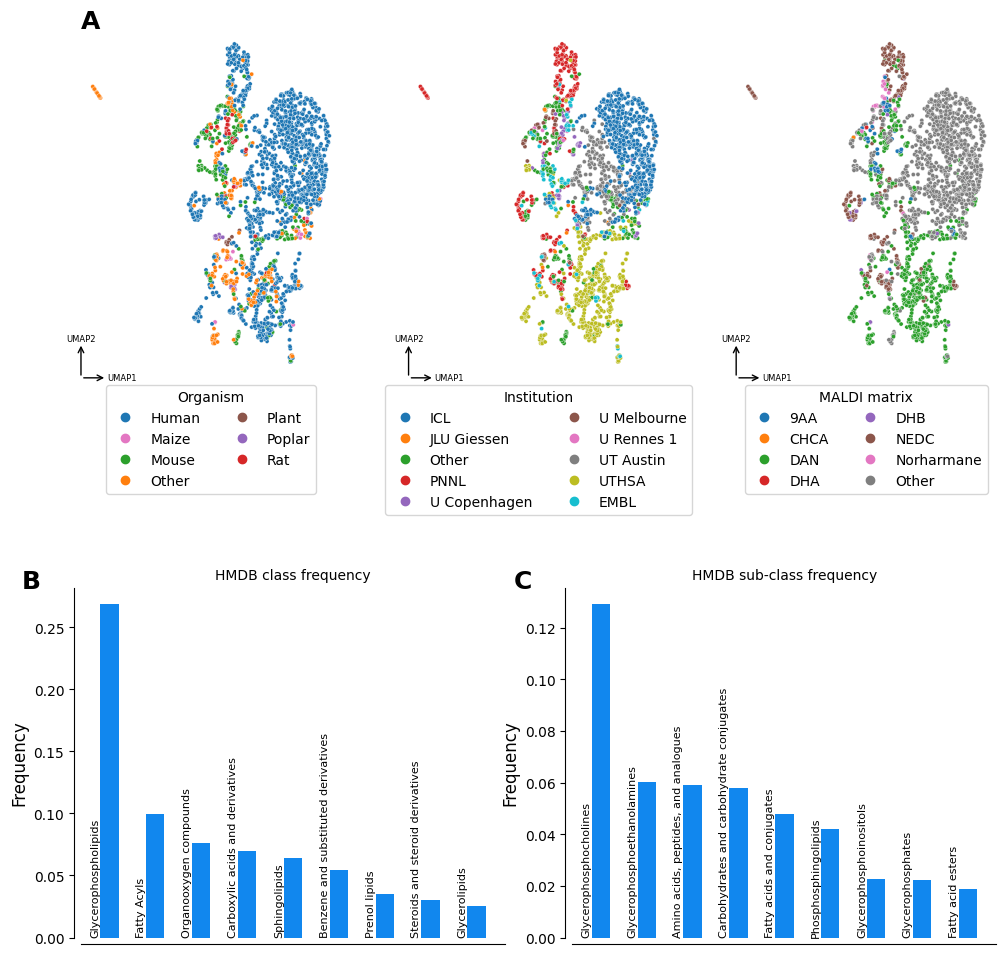

In [63]:
fig = plt.figure(figsize=(30*cm, 30*cm))


gs = plt.GridSpec(nrows=2, ncols=6)

ax_umap1 = fig.add_subplot(gs[0, 0:2])
ax_umap2 = fig.add_subplot(gs[0, 2:4])
ax_umap3 = fig.add_subplot(gs[0, 4:6])

ax_bar1 = fig.add_subplot(gs[1, 0:3])
ax_bar2 = fig.add_subplot(gs[1, 3:6])

fig.subplots_adjust(hspace=.6, wspace=.7)

sns.scatterplot(data=neg_umap.drop(columns=['Organism']).rename(columns={'top_Organism': 'Organism'}), x='x', y='y', hue='Organism', s=9, palette=organism_colors, ax=ax_umap1)
ax_umap1.set_title('')
ax_umap1.axis('off')
draw_umapaxis(ax_umap1)
increase_legend_patchsize(ax_umap1, size=.5, loc='upper center', bbox_to_anchor=(0.5, .0), ncol=2, title='Organism')
ax_ann(fig, ax_umap1, letter='A', size=BIGGER_SIZE, weight='bold')

tmp = neg_umap.rename(columns={'top_Group': 'Institution'})
tmp['Institution'] = tmp['Institution'].replace({'♡EMBL♡': 'EMBL'})
sns.scatterplot(data=tmp, x='x', y='y', hue='Institution', s=9, ax=ax_umap2)
ax_umap2.set_title('')
ax_umap2.axis('off')
increase_legend_patchsize(ax_umap2, size=.5, loc='upper center', bbox_to_anchor=(0.5, .0), ncol=2, title='Institution')
draw_umapaxis(ax_umap2)

sns.scatterplot(data=neg_umap.rename(columns={'top_maldi_matrix': 'MALDI matrix'}), x='x', y='y', hue='MALDI matrix', s=9, ax=ax_umap3)
ax_umap3.set_title('')
ax_umap3.axis('off')
increase_legend_patchsize(ax_umap3, size=.5, loc='upper center', bbox_to_anchor=(0.5, .0), ncol=2, title='MALDI matrix')
draw_umapaxis(ax_umap3)



tmp_dict = metaspace_annotation_class
cd = defaultdict(float)
tmp_l = []
for key, val in tmp_dict.items():
    tmp_classes = [random.choice(x) for x in val]
    tmp_dict = defaultdict(int)
    for it in tmp_classes:
        tmp_dict[it] += 1
    tmp_dict = {key: val/sum(tmp_dict.values()) for key, val in tmp_dict.items()}
    for k2, v2 in tmp_dict.items():
        cd[k2] += v2

cd = {key: val/sum(cd.values()) for key, val in cd.items() if type(key)==str}
cd = dict(sorted(cd.items(), key=lambda item: item[1], reverse=True))
cd = pd.Series({list(cd.keys())[i]: list(cd.values())[i] for i in range(9)})

ax_bar1.bar(range(len(cd)), cd.values, align='edge', color='#1187ee', width=.4)
ax_bar1.set_title('HMDB class frequency')
ax_bar1.set_ylabel('Frequency')
counter=0
for idx in cd.index:
    if idx is np.nan:
        pass
    else:
        ax_bar1.text(counter, 0.0, idx, rotation=90, ha='right', va='bottom', size=SMALLSMALL_SIZE)
        counter += 1
sns.despine(offset=5, trim=False, ax=ax_bar1)
ax_ann(fig, ax_bar1, letter='B', size=BIGGER_SIZE, weight='bold', xoffset=-.05)
ax_bar1.set_xticks([])


tmp_dict = metaspace_annotation_sub_class
cd = defaultdict(float)
tmp_l = []
for key, val in tmp_dict.items():
    tmp_classes = [random.choice(x) for x in val]
    tmp_dict = defaultdict(int)
    for it in tmp_classes:
        tmp_dict[it] += 1
    tmp_dict = {key: val/sum(tmp_dict.values()) for key, val in tmp_dict.items()}
    for k2, v2 in tmp_dict.items():
        cd[k2] += v2

cd = {key: val/sum(cd.values()) for key, val in cd.items() if type(key)==str}
cd = dict(sorted(cd.items(), key=lambda item: item[1], reverse=True))
cd = pd.Series({list(cd.keys())[i]: list(cd.values())[i] for i in range(9)})

ax_bar2.bar(range(len(cd)), cd.values, align='edge', color='#1187ee', width=.4)
ax_bar2.set_title('HMDB sub-class frequency')
ax_bar2.set_ylabel('Frequency')
counter=0
for idx in cd.index:
    if idx is np.nan:
        pass
    else:
        ax_bar2.text(counter, 0.0, idx, rotation=90, ha='right', va='bottom', size=SMALLSMALL_SIZE)
        counter += 1
sns.despine(offset=5, trim=False, ax=ax_bar2)
ax_ann(fig, ax_bar2, letter='C', size=BIGGER_SIZE, weight='bold', xoffset=-.05)
ax_bar2.set_xticks([])


plt.savefig('plots/casestudy1_2.pdf', bbox_inches='tight')

In [28]:
organ_rows = ['Brain', 'Lung', 'Kidney', 'Root']

ds_vis = {
    'Brain': [
        ('2022-01-31_09h08m54s', 'C41H83N2O6P', '+K', []),
        ('2016-09-22_11h16m16s', 'C41H83N2O6P', '+K', []),
        ('2021-12-10_19h17m00s', 'C41H83N2O6P', '+K', []),
        ('2018-05-07_22h32m23s', 'C41H83N2O6P', '+K', []),
    ],
    'Lung': [
        ('2020-12-22_23h04m28s', 'C40H78NO8P', '+Na', []),
        ('2019-12-10_22h08m39s', 'C40H78NO8P', '+Na', []),
        ('2021-08-09_18h51m36s', 'C40H78NO8P', '+H', []),
        ('2020-07-15_16h59m27s', 'C40H78NO8P', '+Na', []),
    ],
    'Kidney': [
        ('2021-01-22_21h03m20s', 'C42H80NO8P', '+K', []),
        ('2021-01-22_23h48m17s', 'C42H80NO8P', '+K', []),
        ('2020-01-16_01h54m35s', 'C42H80NO8P', '+H', []),
        ('2023-06-07_10h57m44s', 'C42H80NO8P', '+H', []),
    ],
    'Root': [
        ('2022-04-16_01h14m55s', 'C12H22O11', '+K', []),
        ('2023-04-02_05h15m09s', 'C12H22O11', '+K', []),
        ('2018-02-05_17h08m20s', 'C12H22O11', '+Na', []),
        ('2018-03-19_16h42m08s', 'C12H22O11', '+K', []),
    ]
}

sm = SMInstance()

for k in ds_vis.keys():
    for d in range(len(ds_vis[k])):
        ds = sm.dataset(id=ds_vis[k][d][0])
        images = ds.isotope_images(ds_vis[k][d][1], ds_vis[k][d][2])
        image = images[0]
        # Hotspot clipping
        hotspot = np.percentile(image, 99)
        image[image > hotspot] = hotspot
        ds_vis[k][d] = (ds_vis[k][d][0], ds_vis[k][d][1], ds_vis[k][d][2], image)
    
    


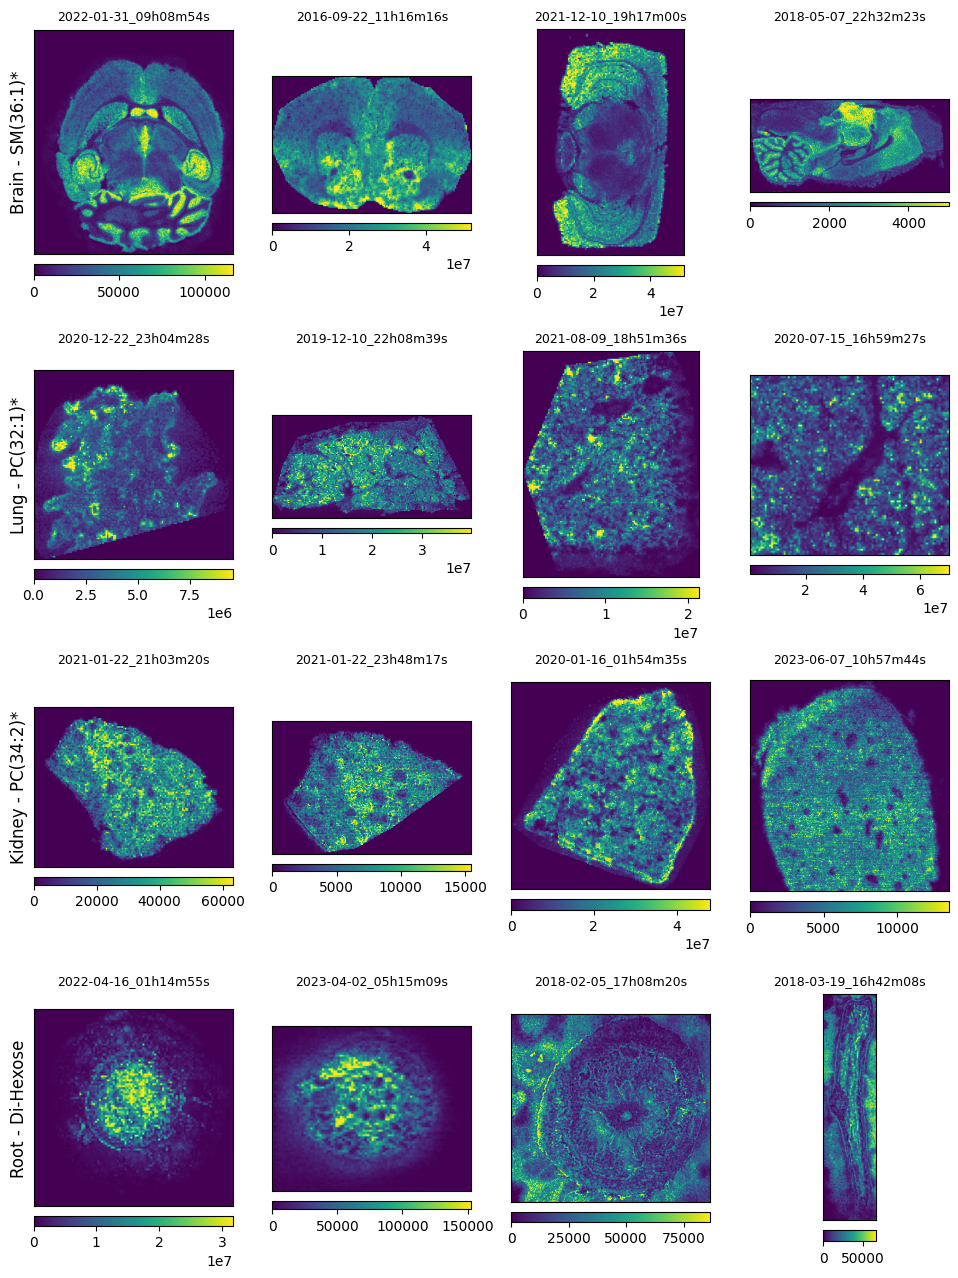

In [34]:
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(30*cm, 40*cm))
fig.subplots_adjust(hspace=.3)

for i in range(len(axs)):
    organ = organ_rows[i]
    for j in range(len(axs[i])):
        image = ds_vis[organ][j][3]
        
        im = axs[i][j].imshow(image)
        image_colorbar(axs[i][j], fig, im, size="5%", pad=0.1, shrink=0.6, location='bottom')
    
        title_x_position = (axs[i][j].get_position().x1 - axs[i][j].get_position().x0)/2 + axs[i][j].get_position().x0

        #axs[i][j].axis('off')

        fig.text(title_x_position, axs[i][j].get_position().y1+0.006, '{}'.format(ds_vis[organ][j][0]), fontsize=9, horizontalalignment='center')
        axs[i][j].set_xticks([])
        axs[i][j].set_yticks([])
        
        if j == 0:
            axs[i][j].set_ylabel('{} - {}'.format(organ, mapping_dict[ds_vis[organ][j][1]]), fontsize=MEDIUM_SIZE)
            
plt.savefig('plots/casestudy1_3.pdf', bbox_inches='tight')